# **Composición de la demanda de combustibles líquidos por producto**

---


El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos de la demanda de combustibles líquidos (gas oil y nafta) publicados por la Secretaría de Energía de la Nación.

La demanda de combustibles líquidos, y -en particular- la del gas oil, se encuentra fuertemente relacionada con las variaciones en la actividad económica, haciendo que su estudio sea relevante.

Como resultado del análisis de datos, se presenta una figura (un gráfico de áreas apiladas) que permite una visualización de la composición mensual de la demanda de combustibles líquidos.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import plotly.graph_objects as go
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00


## Obtención y limpieza de datos

La Secretaría de Energía de la Nación actualiza, mensualmente, un *dataset* nombrado como "Refinación y Comercialización de petróleo, gas y derivados". Este *dataset* recoge, actualiza y re-ordena los datos publicados en la Información Estadística de Hidrocarburos.

En este sentido, los valores mensuales de la demanda de combustibles líquidos son publicados las Tablas Dinámicas SESCO (Downstream) y re-publicados en el recurso "Ventas (excluye ventas a empresas del sector)" del *dataset*.

El link `url_ventas` refiere a dicho recurso, extraido en `.csv`.

In [3]:
url_ventas = "http://datos.energia.gob.ar/dataset/5bdc436c-60d4-4c86-98ab-59834d047700/resource/f0e4e10a-e4b8-44e6-bd16-763a43742107/download/ventas-excluye-ventas-a-empresas-del-sector-.csv"

Se utiliza la *library* `pandas` para leer el archivo.

In [4]:
demanda = pd.read_csv(url_ventas)

El archivo contiene información de las ventas de combustibles líquidos desde enero del año 2010.

Dado que el análisis se efectúa a partir del año 2019, pueden eliminarse todas las filas cuya columna `anio` sea menor a 2019 (esto es, todos los datos anteriores al año 2019).

Al mismo tiempo, se ordenan las filas según el año (`anio`) y el mes (`mes`) y se resetea el índice.

In [5]:
demanda = demanda[demanda["anio"] >= 2019].sort_values(by=["anio", "mes"]).reset_index(drop=True)

Los productos relevados por el *dataset* son múltiples y variados. El análisis se acota a cuatro productos en particular, definidos en la lista `productos`.

In [6]:
productos = ['Gasoil Grado 2 (Común)(m3)',
             'Gasoil Grado 3 (Ultra) (m3)',
             'Nafta Grado 2 (Súper)(m3)',
             'Nafta Grado 3 (Ultra)(m3)']

Luego, se eliminan todas aquellas filas cuya columna "producto" no se encuentre en la lista `productos`.

In [7]:
demanda = demanda[demanda['producto'].isin(productos)]

Luego, se utiliza el método `.groupby()` para agrupar el *DataFrame*. Las columnas "indice_tiempo" y "producto" serán los grupos, y la forma de agregación de los datos (la columna "cantidad") viene dada por una suma (`.sum()`).

In [8]:
demanda = demanda.groupby(["indice_tiempo", "producto"], as_index=False)["cantidad"].sum()

Una vez agrupado el *DataFrame*, este tendrá una orientación "vertical": habrá 4 filas por cada valor en la columna "indice_tiempo", dado que existen 4 valores diferentes para la columna "producto".

Para cambiar la orientación del *DataFrame*, se utiliza el comando `.pivot()`, y se explicita que:
*   la columna "indice_tiempo" debe ser utilizada como índice
*   los valores de la columna "producto" deben ser las columnas del nuevo *DataFrame*
*   los valores de cada una de las columnas antes especificadas deben corresponder a los valores de la columna "cantidad".

In [9]:
demanda = demanda.pivot(index='indice_tiempo', columns='producto', values='cantidad').reset_index()

## *DataFrame* final

La lista `productos_mod` contiene los nombres de los productos antes especificados (lista `productos`) pero adaptados al canal de venta al público.

In [10]:
productos_mod = ["Gas Oil Grado 2", "Gas Oil Grado 3", "Nafta (súper) entre 92 y 95 Ron", "Nafta (premium) de más de 95 Ron"]

Las columnas del *DataFrame* `demanda` se actualizan en función de los nuevos nombres definidos en `productos_mod`.

In [11]:
demanda.columns = ["indice_tiempo"] + productos_mod

Por último, se convierte en `datetime` a la columna "indice_tiempo", para permitir una visualización adecuada.

In [12]:
demanda["indice_tiempo"] = pd.to_datetime(demanda["indice_tiempo"])

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [13]:
demanda.head()

,indice_tiempo,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,764259.581,274954.457,588132.183,202957.526
1,2019-02-01,751179.820,263761.509,549499.248,190109.480
2,2019-03-01,854846.732,277059.884,588694.963,194849.956
3,2019-04-01,872664.043,266159.505,551950.037,176051.463
4,2019-05-01,866385.786,278986.991,570435.086,177799.714


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [14]:
demanda.to_excel("Demanda de combustibles líquidos por producto.xlsx", index=False)

## Figura: Composición de la demanda por producto

Al tratarse de una sola figura, en este caso, no es necesario definir una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta.

Sin embargo, resulta eficiente crear una función para modificar el aspecto de la figura en general. Así, la función `CL_update_layout` contiene el código necesario para esta visualización.

Sus parámetros son:
*   `fig`: el nombre de la figura a utilizar.
*   `df`: el *DataFrame* que contiene la información a graficar.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.

In [15]:
def CL_update_layout(fig, df, min, max, title_text):
  fig.update_layout(
    plot_bgcolor = 'rgba(0,0,0,0)',
    margin = dict(
        b=15,
        t=15,
        l=15,
        r=50
    ),
    legend = dict(
        title = None,
        orientation = 'h',
        xanchor = 'center', 
        x = 0.5, 
        yanchor = 'bottom', 
        y = 1,
        font = dict(
            size = 16
        ),
        traceorder="grouped"),
    height = 750,
    width = 1000,
    xaxis = dict(
        range = [df["indice_tiempo"][0], dt.date(df["indice_tiempo"][len(df)-1].year, df["indice_tiempo"][len(df)-1].month, 28)],
        title = None,
        tickformat = "%m\n<b>%Y",
        dtick = "M6",
        tickangle = 0
        ),
    yaxis = dict(
        range = [min, max],
        title = dict(
            text=title_text
            ),
        showgrid=True,
        gridcolor='lightgray'
        ),
    font = dict(
        size = 14,
        family = "serif"
        )
    )

Se establece un color para cada producto.

In [16]:
colors_producto = ['#3366CC', '#DC3912', '#FF9900', '#109618']

La variable `aggregate_demanda` es:


*   0 si el producto es el Gas Oil Grado 2.
*   El valor de la suma de las demandas inmediatamente anteriores si el producto no es el Gas Oil Grado 2.



In [17]:
aggregate_demanda = []
for column, i in zip(demanda.columns[1:], range(0, len(demanda.columns[1:])+1)):
  if column == demanda.columns[1]:
    aggregate_demanda.append(0)
  else:
    aggregate_demanda.append(demanda[demanda.columns[1:]].cumsum(axis=1).tail(1).values[0].tolist()[i] - demanda[column][len(demanda)-1])

Dado que las áreas deben estar apiladas, la lista `filling` contiene los valores para asegurar una correcta visualización.

In [18]:
filling = ["tozeroy"] + ["tonexty"]*3

Por último, los grupos de las leyendas se ordenan según la lista `legends`.

In [19]:
legends = ["Gas Oil"] * 2 + ["Nafta"] * 2

Se crea la figura `demanda_CL` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [20]:
demanda_CL = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `gas_update_layout` para modificar el aspecto de la figura en general.

In [21]:
for producto, color, legend, agg, fill in zip(demanda.columns[1:].tolist(), colors_producto, legends, aggregate_demanda, filling):
  demanda_CL.add_trace(
    go.Scatter(
      x = demanda["indice_tiempo"],
      y = demanda[producto],
      mode = 'lines',
      legendgroup=legend,
      legendgrouptitle_text=legend,
      name = producto,
      line = dict(
          color = color
      ),
      fill = fill,
      stackgroup = 'one'
    )
  )
  demanda_CL.add_trace(
    go.Scatter(
      showlegend = False,
      name = producto + " - EoP",
      mode = "markers",
      x = demanda["indice_tiempo"].tail(1),
      y = demanda[producto].tail(1) + agg,
      marker = dict(color = color, size=10),
      )
    )
  demanda_CL.add_annotation(
    x = demanda["indice_tiempo"][len(demanda)-1],
    y = demanda[producto][-1:].values[0] + agg,
    text = str(round(demanda[producto][-1:].values[0]/1000000, 2)) + "M",
    font = dict(color = color),
    xanchor = "left",
    xshift = 5,
    yshift = 0,
    showarrow = False
    )

CL_update_layout(demanda_CL, demanda, -2000, 2250000, "<b>m\u00b3")

A continuación, se exhibe la figura.

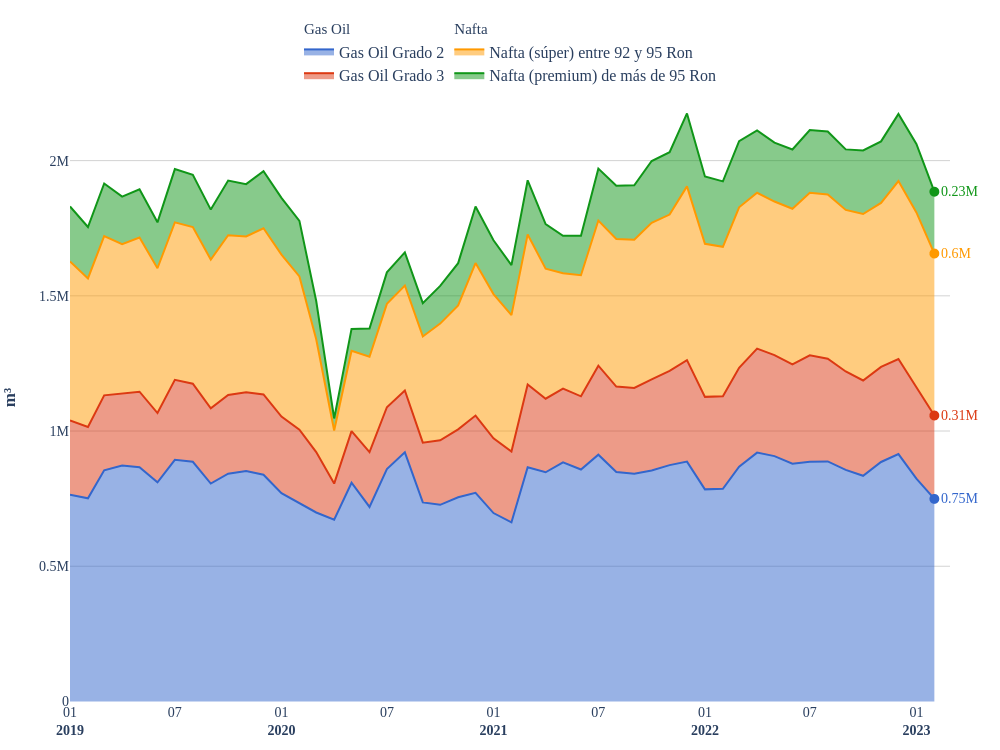

In [22]:
demanda_CL.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [23]:
pio.write_image(demanda_CL, "Figura Demanda Combustibles Liquidos.pdf", width=3*300, height=2.25*300)